<a href="https://colab.research.google.com/github/pratikiiitb2013/ERA/blob/main/S10/ERA1S10_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

%pip install -U albumentations
%pip install -U torch_lr_finder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
#### Transforms - Aug ####
from albumentations import *
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations.dropout.coarse_dropout import CoarseDropout
from albumentations.augmentations.geometric.transforms import PadIfNeeded
from albumentations.augmentations.crops.transforms import CenterCrop

class TrainAlbumentation():
  def __init__(self):
    self.train_transform = Compose([
        Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225],
      ),
      HorizontalFlip(),
      # ShiftScaleRotate(shift_limit=(-0.2, 0.2), scale_limit=(-0.2, 0.2), rotate_limit=(-15, 15), p=0.5),
      PadIfNeeded(min_height=36, min_width=36, pad_height_divisor=None, pad_width_divisor=None, p=1.0),
      RandomCrop (32, 32, always_apply=False, p=1.0),
      Cutout (num_holes=1, max_h_size=8, max_w_size=8, fill_value=[0.485,0.456,0.406], always_apply=False, p=0.5),
      ToTensorV2()
    ])

  def __call__(self, img):
    img = np.array(img)
    img = self.train_transform(image = img)['image']
    return img


class TestAlbumentation():
  def __init__(self):
    self.test_transform = Compose(
    [
      Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225],
      ),
      ToTensorV2()
    ])

  def __call__(self, img):
    img = np.array(img)
    img = self.test_transform(image = img)['image']
    return img

In [ ]:
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=32, pin_memory=True) if torch.cuda.is_available() else dict(shuffle=True, batch_size=512)

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=TrainAlbumentation())
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=TestAlbumentation())
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


100%|██████████| 170498071/170498071 [00:13<00:00, 12908795.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
# dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# # train dataloader
# train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# # test dataloader
# test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


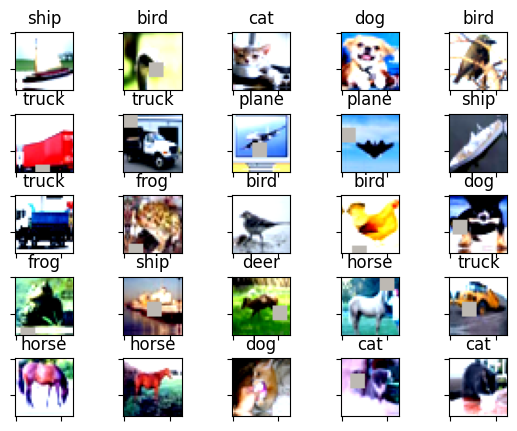

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# print labels
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i in range(0,25):
 plt.subplot(5, 5, i+1)
 frame1 = plt.gca()
 frame1.axes.xaxis.set_ticklabels([])
 frame1.axes.yaxis.set_ticklabels([])
 plt.imshow(np.transpose(((images[i]/2)+0.5).numpy(),(1,2,0)))
 plt.title(classes[labels[i]])

In [ ]:
normtype = 'bn'

def norms(normtype, embedding):
  if normtype=='bn':
     return nn.BatchNorm2d(embedding)
  elif normtype=='ln':
     return nn.GroupNorm(1, embedding)
  else:
    return nn.GroupNorm(4, embedding)

# class depthwise_separable_conv(nn.Module):
#     def __init__(self, nin, nout):
#         super(depthwise_separable_conv, self).__init__()
#         self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin)
#         self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

#     def forward(self, x):
#         out = self.depthwise(x)
#         out = self.pointwise(out)
#         return out

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.prepLayer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            norms(normtype, 64),
            nn.ReLU(),
        )
    ###########################################################
    self.L1_conv = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.MaxPool2d(2, 2),
            norms(normtype, 128),
            nn.ReLU(),
        )
    self.L1_residual = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            norms(normtype, 128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            norms(normtype, 128),
            nn.ReLU(),
        )
    ###########################################################
    self.L2_conv = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.MaxPool2d(2, 2),
            norms(normtype, 256),
            nn.ReLU(),
        )
    ###########################################################
    self.L3_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
            nn.MaxPool2d(2, 2),
            norms(normtype, 512),
            nn.ReLU(),
        )
    self.L3_residual = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
            norms(normtype, 512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
            norms(normtype, 512),
            nn.ReLU(),
        )
    ###########################################################
    self.pool = nn.MaxPool2d(4, 4)
    self.fc_with_1X1 = nn.Conv2d(in_channels=512, out_channels=10, kernel_size=(1, 1), bias=False)




  def forward(self, x):
    x = self.prepLayer(x)

    x1 = self.L1_conv(x)
    r1 = self.L1_residual(x1)
    x = x1 + r1

    x = self.L2_conv(x)

    x3 = self.L3_conv(x)
    r3 = self.L3_residual(x3)
    x = x3 + r3

    x = self.pool(x)

    x = self.fc_with_1X1(x)

    x = x.view(-1, 10)

    return x

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = Net().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.38E-02


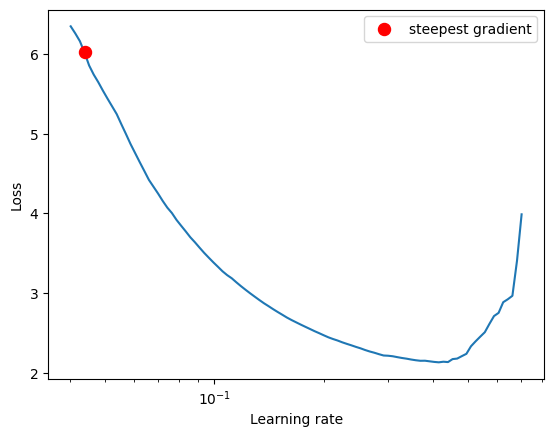

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
from torch_lr_finder import LRFinder
# train_criterion = nn.CrossEntropyLoss()
# test_criterion = nn.CrossEntropyLoss(reduction='sum')
train_criterion = F.nll_loss
test_criterion = F.nll_loss
optimizer = torch.optim.Adam(net.parameters(), lr=0.03, weight_decay=1e-4)
lr_finder = LRFinder(net, optimizer, train_criterion, device='cuda')
lr_finder.range_test(trainloader,end_lr=10, num_iter=200, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

In [ ]:
import torch
from torch.optim import lr_scheduler

EPOCHS = 24

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=6.22E-02,
                                    steps_per_epoch=len(trainloader),
                                    epochs=EPOCHS,
                                    pct_start=5/EPOCHS,
                                    div_factor=100,
                                    final_div_factor=100,
                                    three_phase=False,
                                    anneal_strategy='linear')



In [ ]:
len(trainloader.dataset)
len(testloader.dataset)

10000

In [ ]:
# import torch
# from tqdm import tqdm

# train_losses = []
# train_acc = []

# def train(net, device, trainloader, optimizer, scheduler, criterion, epoch):
#   net.train()
#   pbar = tqdm(trainloader)
#   running_loss = 0.0
#   for i, (data, target) in enumerate(pbar):
#         # get the inputs
#         correct = 0
#         processed = 0
#         data, target = data.to(device), target.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(data)
#         loss = criterion(outputs, target)
#         loss.backward()
#         scheduler.step()

#         # Predict
#         y_pred = net(data)
#         pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#         correct += pred.eq(target.view_as(pred)).sum().item()
#         processed += len(data)
#         #pbar.set_description(desc= f'Epoch= {epoch} Loss={loss.item()} Batch_id={i} Accuracy={100*correct/processed:0.2f}')
#         pbar.update(1)
#   train_acc = 100*correct/processed
#   print(f'Epoch= {epoch} Loss={loss.item()} Accuracy={100*correct/processed:0.2f}')
#   return train_acc

# def test(net, device, testloader):
#   net.eval()
#   correct = 0
#   total = 0
#   with torch.no_grad():
#       pbar1 = tqdm(testloader)
#       for i, (data, target) in enumerate(pbar1):
#           data, target = data.to(device), target.to(device)
#           outputs = net(data)
#           _, predicted = torch.max(outputs.data, 1)
#           total += target.size(0)
#           correct += (predicted == target).sum().item()

#       print('Accuracy of the network on the 10000 test images: %0.2f %%' % (100 * correct / total))
#   test_acc = (100 * correct / total)

#   return test_acc

# def test_categorywise(net, device, testloader, classes):
#    class_correct = list(0. for i in range(10))
#    class_total = list(0. for i in range(10))
#    with torch.no_grad():
#       pbar = tqdm(testloader)
#       for i, (data, target) in enumerate(pbar):
#         data, target = data.to(device), target.to(device)
#         outputs = net(data)
#         _, predicted = torch.max(outputs, 1)
#         c = (predicted == target).squeeze()
#         for i in range(4):
#             label = target[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1


#    for i in range(10):
#       print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, scheduler, criterion):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    # print(correct)
    # print(processed)
    # print(len(train_losses))

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            # test_loss += criterion(output, target, reduction = 'sum').item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
# import torch
# from tqdm import tqdm
# # import traine, teste
# #import test
# test_acc = []
# train_acc = []
# learning_rate = []
# for epoch in range(24):  # loop over the dataset multiple times
#     # scheduler.step()
#     for param_group in optimizer.param_groups:
#       print("lr= ",param_group['lr'])
#     # train_acc.append(train(net, device, trainloader, optimizer, scheduler, criterion, epoch))
#     # test_acc.append(test(net, device, testloader))
#     # learning_rate.append(param_group['lr'])
#     train(net, device, trainloader, optimizer, epoch, scheduler, train_criterion)
#     test(net, device, testloader,test_criterion)
# print('Finished Training')

In [ ]:
import torch
from tqdm import tqdm
from torch.optim import lr_scheduler

EPOCHS = 24

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr=4.38E-02,
                                    steps_per_epoch=len(trainloader),
                                    epochs=EPOCHS,
                                    pct_start=5/EPOCHS,
                                    div_factor=100,
                                    final_div_factor=100,
                                    three_phase=False,
                                    anneal_strategy='linear')


test_acc = []
train_acc = []
learning_rate = []
for epoch in range(24):  # loop over the dataset multiple times
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
    train(net, device, trainloader, optimizer, epoch, scheduler, train_criterion)
    test(net, device, testloader,test_criterion)
print('Finished Training')

lr=  0.00043799999999999997


Loss=1.0158365964889526 Batch_id=97 Accuracy=51.97: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]



Test set: Average loss: 1.0734, Accuracy: 6311/10000 (63.11%)

lr=  0.009128134969325151


Loss=0.8400256633758545 Batch_id=97 Accuracy=68.72: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 1.4212, Accuracy: 6138/10000 (61.38%)

lr=  0.017818269938650304


Loss=0.576158344745636 Batch_id=97 Accuracy=74.35: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]



Test set: Average loss: 0.9760, Accuracy: 7165/10000 (71.65%)

lr=  0.026508404907975458


Loss=0.6088658571243286 Batch_id=97 Accuracy=79.79: 100%|██████████| 98/98 [00:31<00:00,  3.08it/s]



Test set: Average loss: 0.6611, Accuracy: 7756/10000 (77.56%)

lr=  0.03519853987730061


Loss=0.6023464202880859 Batch_id=97 Accuracy=82.17: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]



Test set: Average loss: 0.5813, Accuracy: 8066/10000 (80.66%)

lr=  0.04377647925886144


Loss=0.39269328117370605 Batch_id=97 Accuracy=84.55: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]



Test set: Average loss: 0.6145, Accuracy: 8022/10000 (80.22%)

lr=  0.04147144662728249


Loss=0.35578417778015137 Batch_id=97 Accuracy=87.19: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 0.4528, Accuracy: 8544/10000 (85.44%)

lr=  0.039166413995703545


Loss=0.24921256303787231 Batch_id=97 Accuracy=88.64: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]



Test set: Average loss: 0.5523, Accuracy: 8386/10000 (83.86%)

lr=  0.0368613813641246


Loss=0.3073972165584564 Batch_id=97 Accuracy=89.89: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]



Test set: Average loss: 0.5140, Accuracy: 8462/10000 (84.62%)

lr=  0.03455634873254565


Loss=0.3205534517765045 Batch_id=97 Accuracy=90.85: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]



Test set: Average loss: 0.4710, Accuracy: 8526/10000 (85.26%)

lr=  0.0322513161009667


Loss=0.20384952425956726 Batch_id=97 Accuracy=92.12: 100%|██████████| 98/98 [00:34<00:00,  2.84it/s]



Test set: Average loss: 0.3509, Accuracy: 8868/10000 (88.68%)

lr=  0.029946283469387755


Loss=0.28809699416160583 Batch_id=97 Accuracy=92.35: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]



Test set: Average loss: 0.3628, Accuracy: 8867/10000 (88.67%)

lr=  0.027641250837808804


Loss=0.1549982875585556 Batch_id=97 Accuracy=93.62: 100%|██████████| 98/98 [00:30<00:00,  3.21it/s]



Test set: Average loss: 0.4491, Accuracy: 8698/10000 (86.98%)

lr=  0.025336218206229857


Loss=0.15157285332679749 Batch_id=97 Accuracy=94.19: 100%|██████████| 98/98 [00:31<00:00,  3.08it/s]



Test set: Average loss: 0.3807, Accuracy: 8821/10000 (88.21%)

lr=  0.02303118557465091


Loss=0.1858448088169098 Batch_id=97 Accuracy=95.17: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]



Test set: Average loss: 0.3535, Accuracy: 8940/10000 (89.40%)

lr=  0.020726152943071965


Loss=0.12031147629022598 Batch_id=97 Accuracy=95.75: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]



Test set: Average loss: 0.3769, Accuracy: 8961/10000 (89.61%)

lr=  0.018421120311493018


Loss=0.0928523913025856 Batch_id=97 Accuracy=96.54: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.3479, Accuracy: 9054/10000 (90.54%)

lr=  0.01611608767991407


Loss=0.07470107823610306 Batch_id=97 Accuracy=96.76: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]



Test set: Average loss: 0.3428, Accuracy: 9075/10000 (90.75%)

lr=  0.01381105504833512


Loss=0.07248756289482117 Batch_id=97 Accuracy=97.48: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]



Test set: Average loss: 0.3334, Accuracy: 9107/10000 (91.07%)

lr=  0.011506022416756176


Loss=0.04267062619328499 Batch_id=97 Accuracy=98.02: 100%|██████████| 98/98 [00:30<00:00,  3.16it/s]



Test set: Average loss: 0.3167, Accuracy: 9185/10000 (91.85%)

lr=  0.009200989785177228


Loss=0.03852495178580284 Batch_id=97 Accuracy=98.29: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]



Test set: Average loss: 0.3065, Accuracy: 9222/10000 (92.22%)

lr=  0.006895957153598281


Loss=0.024785539135336876 Batch_id=97 Accuracy=98.70: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]



Test set: Average loss: 0.2977, Accuracy: 9238/10000 (92.38%)

lr=  0.004590924522019334


Loss=0.027110209688544273 Batch_id=97 Accuracy=99.01: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]



Test set: Average loss: 0.2826, Accuracy: 9276/10000 (92.76%)

lr=  0.0022858918904403863


Loss=0.02008882537484169 Batch_id=97 Accuracy=99.24: 100%|██████████| 98/98 [00:31<00:00,  3.15it/s]



Test set: Average loss: 0.2832, Accuracy: 9280/10000 (92.80%)

Finished Training
